### TODO
- Everything
- Drop users that have rated very few movies -> How to decide the threshold?
- Define the best approach to the collaborative filtering (model-based or memory-based)
- Build the recommender system (can it be as simple as kNN?)

### DONE
- File loading and creation of the DataFrame

In [1]:
# Imports
import os
import gc
import sys
import math

# from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from surprise import Reader, Dataset, SVD, KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV


# # Not being used yet.
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.pipeline import Pipeline

# from scipy.sparse import csr_matrix

# from scipy.spatial import Voronoi, voronoi_plot_2d
# from imblearn.over_sampling import SMOTE

sns.set_theme(style="darkgrid")

In [2]:
# Read Movie Titles file
def readMovieTitle(file_path):
    data_dict = {'Movie_Id' : [], 'Release_Year' : [], 'Title' : []}
    data_file = open(file_path, "r", encoding='ISO-8859-1')
    for line in data_file:            
        id, year, title = line.split(',', 2)
        data_dict['Movie_Id'].append(id)
        data_dict['Release_Year'].append(year)
        data_dict['Title'].append(title.rstrip('\n'))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [3]:
# The dataset is very large, so there's a flag to load only a handful of rows if necessary
# First 1M lines takes 0.2s to load, the whole dataset takes almost 2 minutes
cid_list = {}
def readFile(file_path, rows = 1000000, flag = False):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    data_file = open(file_path, "r")
    count = 0
    for line in data_file:
        count += 1
        if flag and (count > rows):
            break
            
        if ':' in line:
            movieId = line[:-2] # remove the last character ':'
            movieId = int(movieId)
        else:
            customerID, rating, date = line.split(',')
            if (customerID not in cid_list):
                cid_list[customerID] = 1
            else:
                cid_list[customerID] += 1
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    data_file.close()
            
    return pd.DataFrame(data_dict)

In [4]:
# Load the title of the movies into a dataframe
df_title = readMovieTitle('data/movie_titles.csv')
df_title['Movie_Id'] = df_title['Movie_Id'].astype(int)
df_title.head(10)
# df_title.loc[df_title['Movie_Id'] == 1]

,Movie_Id,Release_Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
6,7,1992,8 Man
7,8,2004,What the #$*! Do We Know!?
8,9,1991,Class of Nuke 'Em High 2
9,10,2001,Fighter


In [5]:
# Loading the user data
# User ID, Movie ID, Rating and Date
flag_limit = False
df1 = readFile('data/combined_data_1.txt', flag = flag_limit)
df2 = readFile('data/combined_data_2.txt', flag = flag_limit)
df3 = readFile('data/combined_data_3.txt', flag = flag_limit)
df4 = readFile('data/combined_data_4.txt', flag = flag_limit)
# Transform everything to INT, occupies less RAM.
df1['Rating'] = df1['Rating'].astype(int)
df2['Rating'] = df2['Rating'].astype(int)
df3['Rating'] = df3['Rating'].astype(int)
df4['Rating'] = df4['Rating'].astype(int)
df1['Cust_Id'] = df1['Cust_Id'].astype(int)
df2['Cust_Id'] = df2['Cust_Id'].astype(int)
df3['Cust_Id'] = df3['Cust_Id'].astype(int)
df4['Cust_Id'] = df4['Cust_Id'].astype(int)

In [6]:
# Creation of the DataFrame with all the data
df = df1.copy()
df = pd.concat([df1, df2, df3, df4])
df.index = np.arange(0,len(df))
df.head(10)
# Drop everything but the essential information
df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Rating']]
original = df

# # Complete Dataframe with the movie titles
# # Not necessary
# df = df.merge(df_title, how='left')
# df = df.loc[:, ['Cust_Id', 'Movie_Id', 'Title', 'Release_Year', 'Rating', 'Date']]
# df.head(-10)

# Too much data, so I'm deleting the dataframes after the merge
# In total it uses 14gb of memory
del df1, df2, df3, df4, # df_title
# Explicitily calling the garbage collector to free up RAM
gc.collect()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   Cust_Id   int64
 1   Movie_Id  int64
 2   Rating    int64
dtypes: int64(3)
memory usage: 3.0 GB


After the successful loading of the data into a single large dataframe, now it's time to understand the data and do a little bit of a clean up (delete rows with NaN values, look for duplicates, drop unnecessary columns etc.)

In [9]:
# General format of the Dataframe
df.head(10)

,Cust_Id,Movie_Id,Rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3
5,893988,1,3
6,124105,1,4
7,1248029,1,3
8,1842128,1,4
9,2238063,1,3


In [10]:
df.shape

(100480507, 3)

In [11]:
# Check if there are empty rows
# Not necessary, data is clean
#df.isna().sum()

In [12]:
# Check if there are duplicated values
# Not necessary, data is clean
# df.duplicated().sum()
# If there were duplicates
# df = df.loc[~df.duplicated()].reset_index(drop=True).copy()

In [13]:
# Check the type of the variables.
# Here we identify that some are loaded as a type we don't want and thus need to transform it
# Int occupies less memory
df.dtypes

Cust_Id     int64
Movie_Id    int64
Rating      int64
dtype: object

In [14]:
# Changing the types -> already did during loading, not necessary
# df['Cust_Id'] = df['Cust_Id'].astype(int)
# df['Release_Year'] = df['Release_Year'].astype(int)
# df['Date'] = pd.to_datetime(df['Date'])
# gc.collect()
# df.dtypes

Now the dataset is clean (it already was, but nonetheless this should be part of the pipeline)
Let's investigate the data, i.e. do Feature Understanding
Histogram, KDE, Boxplot

In [15]:
df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).mean()

5654.502363534046

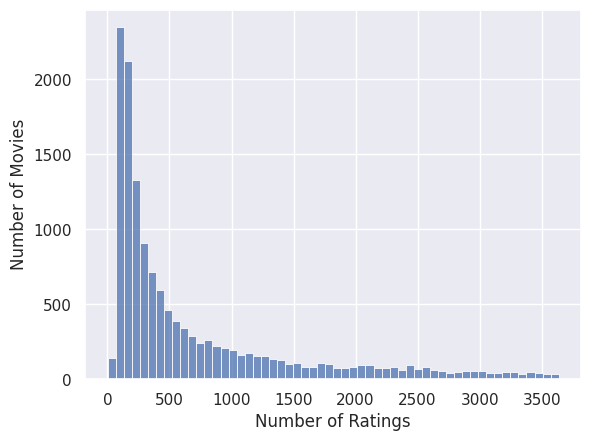

In [16]:
mr = df.groupby('Movie_Id')['Rating'].count().sort_values(ascending=True).head(14000)

ax = sns.histplot(data=mr)
ax.bar_label(ax.containers[0])
plt.axis('on')
plt.xlabel('Number of Ratings')
plt.xscale('linear')
plt.ylabel('Number of Movies')
plt.show()

In [17]:
mr.tail(10)

df_title.loc[(df_title['Movie_Id'] == 5317)]

,Movie_Id,Release_Year,Title
5316,5317,2000,Miss Congeniality


In [18]:
# Number of unique movies
movie_count = df['Movie_Id'].nunique()

# Number of unique customers
cust_count = df['Cust_Id'].nunique()

# Number of ratings
rating_count = df['Cust_Id'].count()

# How many ratings for each value (1-5)
rating_dist = df['Rating'].value_counts().sort_index()

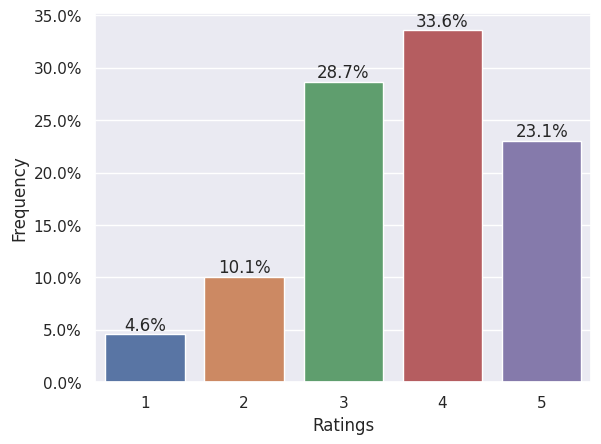

In [19]:
# Histogram of the frequency of ratings
rd = [(i/sum(rating_dist)*100) for i in rating_dist]

ax = sns.barplot(x = np.arange(1,len(rd)+1), y = rd)
ax.bar_label(ax.containers[0], fmt = '%.1f%%')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.axis('on')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()


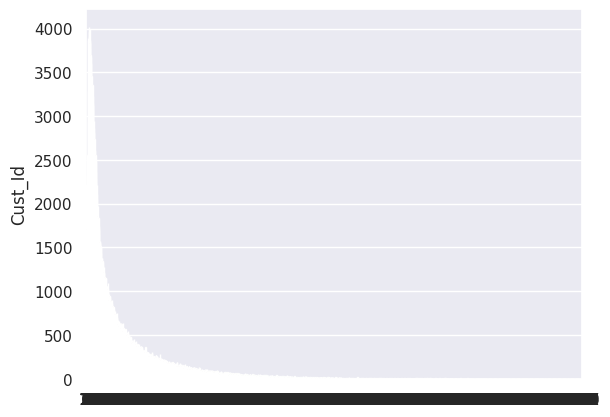

In [20]:
# Histogram of the frequency of reviews by users
cust_rating_dist = df['Cust_Id'].value_counts().sort_values()

crd = cust_rating_dist.value_counts().sort_index()

ax = sns.barplot(x = np.arange(len(crd)), y = crd) 
plt.show()

The data is pretty huge, after understanding it's intrincacies, we've decided to work only with the movies and users that were in the 75% quantile

In [21]:
f = ['count','mean']
quantile = 0.75

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(quantile),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(quantile),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 2668.0
Customer minimum times of review: 259.0


In [22]:
# Checking the favorite movies of a random user (df['Cust_Id'].mode() -> users with most reviews)
df.loc[(df['Cust_Id'] == 305344) & (df['Rating'] >= 4)].reset_index(drop=True)

,Cust_Id,Movie_Id,Rating
0,305344,12,4
1,305344,15,5
2,305344,31,4
3,305344,72,4
4,305344,78,4
...,...,...,...
2098,305344,17727,4
2099,305344,17739,5
2100,305344,17742,4
2101,305344,17747,4


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   Cust_Id   int64
 1   Movie_Id  int64
 2   Rating    int64
dtypes: int64(3)
memory usage: 3.0 GB


In [85]:
df = original.copy()

# df.info()

# Reducing the dataset so it works with reasonable RAM consumption
drop_percentage = 0.99
train_percentage = 0.99
cid_as_int = list(map(lambda x: int(x), cid_list.keys()))
cid_as_str = list(map(lambda x: x, cid_list.keys()))
cid_df = pd.DataFrame(data={"Cust_Id": cid_as_int})

# print(cid_df)
arr_cid_to_drop = default_rng().choice(cid_df.index, size=(math.floor(len(cid_df)*drop_percentage)), replace=False)
cid_df.drop(index=arr_cid_to_drop, inplace=True)
mask1 = df["Cust_Id"].isin(cid_df["Cust_Id"].tolist())
df = df[df["Cust_Id"].isin(cid_df["Cust_Id"].tolist())]
# df.info()

arr_cid_train = default_rng().choice(cid_df.index, size=(math.floor(len(cid_df)*(1 - train_percentage))), replace=False)
cid_train_df = cid_df.drop(index=arr_cid_train, inplace=False)
mask = df["Cust_Id"].isin(cid_train_df["Cust_Id"].tolist())
df_train = df[df["Cust_Id"].isin(cid_train_df["Cust_Id"].tolist())]
df_test = df[~df["Cust_Id"].isin(cid_train_df["Cust_Id"].tolist())]
# for everyone in df_test:
#     remove 1 rated movie
cids_to_remove_rating = list(dict.fromkeys(list(df_test["Cust_Id"])))
print(cids_to_remove_rating)
df_users = []
tuples = []
# for i in range(len(cids_to_remove_rating)):
#     cid = cids_to_remove_rating[i]
#     df_users[cid] = df[df["Cust_Id"] == cid].copy()
#     a = df_users[cid].sample()
#     print(a)
#     print(df_users[cid])
#     print(a.index[0])
#     tuples.append([cid, a.at[a.index[0],"Movie_Id"], a.at[a.index[0],"Rating"]])
#     print(tuples)
#     df_users[cid].loc[a.index[0],"Rating"] = 0

for i in range(len(cids_to_remove_rating)):
    cid = cids_to_remove_rating[i]
    df_users.append(df[df["Cust_Id"] == cid].copy())
    a = df_users[i].sample()
    tuples.append([a.index[0], cid, a.at[a.index[0],"Movie_Id"], a.at[a.index[0],"Rating"]])
    df_users[i].drop(index=[a.index[0]], inplace=True)

print(tuples)
df_reconstructed = pd.concat(df_users)
print(df_reconstructed)
print(df_train)
df_final = pd.concat([df_train, df_reconstructed])
print(df_final)
#     df_test
# print(df_test)
# df_test["Cust_Id"]
# print(df_test)

[6384, 2447273, 548578, 2114016, 2447861, 1763128, 1566853, 2497400, 805884, 1301764, 2526342, 1324010, 1609964, 1938296, 2585815, 2466473, 2614711, 1023512, 827057, 2070435, 1934282, 1808395, 1854424, 19144, 2637332, 84772, 1424698, 1620494, 1645222, 1995649, 1531976, 2449866, 864564, 2034341, 1097317, 866101, 1886629, 863863, 1842318, 1809923, 994391, 416817, 1455330, 720257, 2588520, 1371651, 711916, 1326603]
[[49786921, 6384, 8966, 3], [42387350, 2447273, 7513, 5], [37921929, 548578, 6739, 4], [69442109, 2114016, 12582, 3], [80996711, 2447861, 14554, 4], [55252035, 1763128, 10108, 2], [80908890, 1566853, 14550, 5], [1784475, 2497400, 331, 4], [31383451, 805884, 5732, 4], [76177474, 1301764, 13772, 5], [99901318, 2526342, 17624, 4], [70948062, 1324010, 12870, 3], [80828327, 1609964, 14545, 4], [49982956, 1938296, 9006, 5], [53328864, 2585815, 9689, 4], [96003529, 2466473, 17004, 4], [49370669, 2614711, 8881, 4], [62772707, 1023512, 11398, 3], [88614341, 827057, 15758, 3], [3194880, 

In [86]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_train[['Cust_Id', 'Movie_Id', 'Rating']], reader)
# dataTest = Dataset.load_from_df(df_test[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainingSet = data.build_full_trainset()
# testSet = dataTest.build_full_trainset()
svd = SVD()
svd.fit(trainingSet)
# svd.fit(trainingSet).test(testSet)

In [98]:
successTimes = 0

for i in range(len(tuples)):
    index = tuples[i][0]
    cid = tuples[i][1]
    movId = tuples[i][2]
    rating = tuples[i][3]
    est = svd.predict(cid, movId).est
    print(f"Customer {cid}, Film {movId}. Real evaluation: {rating}. Predicted: {est}")
    # floor + 0.5 = closest integer
    if math.floor(est + 0.5) == rating:
        successTimes = successTimes + 1
#     print(svd.predict(cid, movId).est)

print(f"Success rate: {successTimes / len(tuples)}")

Customer 6384, Film 8966. Real evaluation: 3. Predicted: 3.429326876433188
Customer 2447273, Film 7513. Real evaluation: 5. Predicted: 3.9400652692339757
Customer 548578, Film 6739. Real evaluation: 4. Predicted: 4.256944001441905
Customer 2114016, Film 12582. Real evaluation: 3. Predicted: 3.9575247269318194
Customer 2447861, Film 14554. Real evaluation: 4. Predicted: 4.031327758134437
Customer 1763128, Film 10108. Real evaluation: 2. Predicted: 3.0996728470219415
Customer 1566853, Film 14550. Real evaluation: 5. Predicted: 4.628964605011586
Customer 2497400, Film 331. Real evaluation: 4. Predicted: 3.6199818885187454
Customer 805884, Film 5732. Real evaluation: 4. Predicted: 4.226084965512796
Customer 1301764, Film 13772. Real evaluation: 5. Predicted: 3.2562706178588687
Customer 2526342, Film 17624. Real evaluation: 4. Predicted: 3.214293745393608
Customer 1324010, Film 12870. Real evaluation: 3. Predicted: 4.432426910981055
Customer 1609964, Film 14545. Real evaluation: 4. Predicte

In [ ]:
def benchmark(model, user):
    for 

In [32]:
# Reducing the dataset so it works with reasonable RAM consumption
# Naive approach, dropping individual rating instead of customers

# trainingSet = {}

# drop_percentage = 0.90
# train_percentage = 0.8

In [47]:
# len(df.index)

301441521

In [46]:
# size = math.floor(len(df.index)*(drop_percentage))
# print(size, len(df.index))
# arr_indices_top_drop = default_rng().choice(df.index, size=size, replace=False)
# print(arr_indices_top_drop, type(arr_indices_top_drop))
# df.drop(index=arr_indices_top_drop, inplace=True)

90432 100481
[ 2828130 55532628 97471973 ... 12283498 20419618 84291747] <class 'numpy.ndarray'>


In [49]:
# Creating the dataset inside Surprise
# Surprise accepts by default only this 3 parameters \/
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainingSet = data.build_full_trainset()

In [50]:
# Using SVD for recomendation
# Copied this online -> don't fully understand.
svd = SVD()
# user_305344 = df_title.copy()
# user_305344 = user_305344.reset_index()

svd.fit(trainingSet)

       Movie_Id                                  Title  Estimate_Score
5317       5318                              Tommy Boy        4.969855
7638       7639      Star Wars Trilogy: Bonus Material        4.509225
5367       5368               Dawson's Creek: Season 2        4.500125
3669       3670                             Encino Man        4.426419
312         313                         Pay It Forward        4.344556
16991     16992                                   Emma        4.266193
5444       5445                     Farscape: Season 1        4.259657
1201       1202            National Lampoon's Vacation        4.245958
4423       4424          Elton John: Live in Barcelona        4.244472
10087     10088                     Clerks: Uncensored        4.235431
17750     17751                   Highlander: Season 2        4.222356
2208       2209                         On Golden Pond        4.221021
16721     16722  The Godfather Trilogy: Bonus Material        4.213385
11226 

In [53]:
idx = 305344
user_305344 = df_title.copy()
user_305344 = user_305344.reset_index()
user_305344['Estimate_Score'] = user_305344['Movie_Id'].apply(lambda x: svd.predict(305344, x).est)

# user_305344 = user_305344.drop('Movie_Id', axis = 1)

user_305344_data = user_305344.sort_values('Estimate_Score', ascending=False)
print(user_305344_data[['Movie_Id', 'Title', 'Estimate_Score']].head(20))

       Movie_Id                                  Title  Estimate_Score
5317       5318                              Tommy Boy        4.969855
7638       7639      Star Wars Trilogy: Bonus Material        4.509225
5367       5368               Dawson's Creek: Season 2        4.500125
3669       3670                             Encino Man        4.426419
312         313                         Pay It Forward        4.344556
16991     16992                                   Emma        4.266193
5444       5445                     Farscape: Season 1        4.259657
1201       1202            National Lampoon's Vacation        4.245958
4423       4424          Elton John: Live in Barcelona        4.244472
10087     10088                     Clerks: Uncensored        4.235431
17750     17751                   Highlander: Season 2        4.222356
2208       2209                         On Golden Pond        4.221021
16721     16722  The Godfather Trilogy: Bonus Material        4.213385
11226 

In [54]:
user_305344

,index,Movie_Id,Release_Year,Title,Estimate_Score
5317,5317,5318,1995,Tommy Boy,4.969855
7638,7638,7639,2004,Star Wars Trilogy: Bonus Material,4.509225
5367,5367,5368,1998,Dawson's Creek: Season 2,4.500125
3669,3669,3670,1992,Encino Man,4.426419
312,312,313,2000,Pay It Forward,4.344556
...,...,...,...,...,...
12189,12189,12190,1955,Lola Montes,1.000000
1928,1928,1929,1978,Go Tell the Spartans,1.000000
12180,12180,12181,1995,In the Mouth of Madness,1.000000
974,974,975,1997,Convict 762,1.000000


In [ ]:
# reader = Reader(rating_scale=(1, 5))
# svd = SVD()

# data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
# #data.split(n_folds=3)

# cross_validate(svd, data, measures=['RMSE', 'MAE'])

In [ ]:
# # Grid Search to find the best parameters for SVD
# param_grid = {
#     "n_epochs": [5, 10],
#     "lr_all": [0.002, 0.005],
#     "reg_all": [0.4, 0.6]
# }
# gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

# gs.fit(data)

# print(gs.best_score["rmse"])
# print(gs.best_params["rmse"])

In [ ]:
# # Appplying Best Parameters to predict the score of the same movie and user predicted by kNN
# algo = gs.best_estimator["rmse"]
# algo.fit(data.build_full_trainset())

# prediction = algo.predict(305344, 9235)
# print(prediction.est)